In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#phi = (np.sqrt(5)+1)/2
fig_width = 5
%load_ext autoreload
%autoreload 2

In [2]:
np.random.seed(42)

# Fix hexagonal points

### Set square pattern

In [3]:
N = 121
N_X = int(np.sqrt(N))
N_Y = N // N_X
xv_square, yv_square = np.meshgrid(np.arange(N_X), np.arange(N_Y), sparse=False, indexing='xy')


### Convert into hexagonal pattern

In [4]:
ratio = np.sqrt(3)/2 * 2
xv_hexagonal, yv_hexagonal = np.meshgrid(np.arange(N_X), np.arange(N_Y), sparse=False, indexing='xy')

In [5]:
xv_hexagonal = xv_hexagonal * ratio
xv_hexagonal[::2, :] += ratio/2

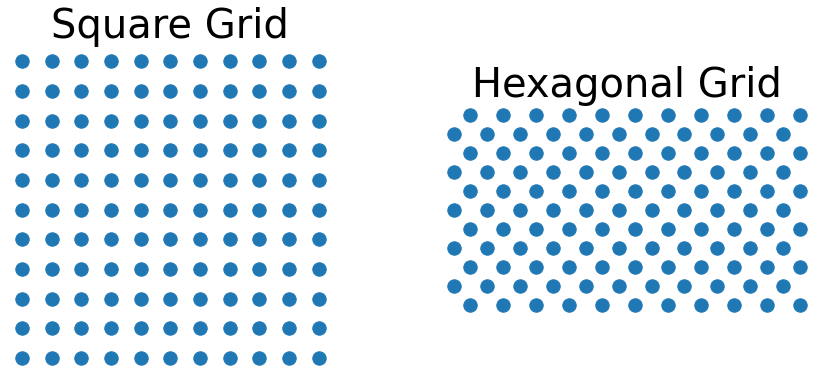

In [6]:
fz = 40
marker_size  = 180
fig,ax = plt.subplots(1,2,figsize = (15,6))


ax[0].scatter(xv_square,yv_square, s=marker_size)
ax[1].scatter(xv_hexagonal, yv_hexagonal, s=marker_size)

ax[0].set_title("Square Grid",fontsize=fz)
ax[1].set_title("Hexagonal Grid",fontsize=fz)

for aa in ax:
    aa.set_aspect("equal")
    aa.axis("off")

# Assign values to Hexagonal Grid

In [7]:
grid = np.zeros((N_X,N_Y))

In [8]:
def take_step(pos, shape):
    x = np.random.choice([-1,0,1])
    y = np.random.choice([-1,0,1])
    for k,s in enumerate([x,y]):
        if pos[k] + s < shape[k] and pos[k] + s >= 0:
            pos[k] = pos[k] + s
    return pos

In [9]:
n_steps = int(1e4)
shape = (N_X,N_Y)
pos = np.array([np.random.uniform(0,shape[0],size=1).astype(int)[0], 
                np.random.uniform(0,shape[1],size=1).astype(int)[0]])
grid[pos[0],pos[1]] = 1
for step in range(n_steps):
    pos = take_step(pos, shape)
    grid[pos[0],pos[1]] += 1

In [10]:
original_values = grid.flatten()

In [11]:
original_positions = np.vstack([xv_square.flatten(), yv_square.flatten()]).T

In [12]:
def grid2img(positions, values, shape):
    img = np.zeros(shape)
    for v, p in zip(values,positions):
        img[(p[0]), p[1]] = v
    return np.rot90(img)

In [13]:
original_img = grid2img(original_positions, original_values, (N_X,N_Y))

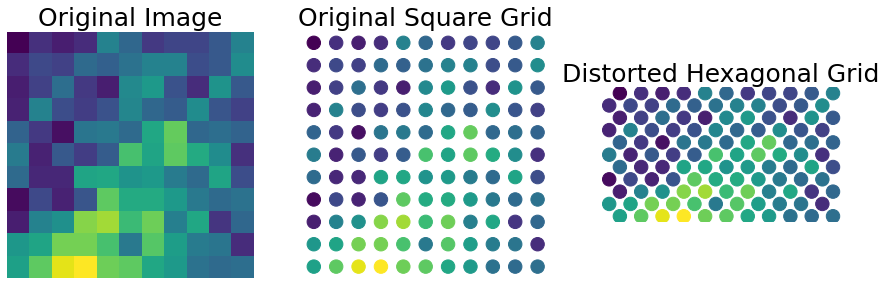

In [30]:
fig,ax = plt.subplots(1,3,figsize = (15,6))

ax[0].imshow(original_img)
ax[1].scatter(xv_square, yv_square, c = original_values, s=marker_size)
ax[2].scatter(xv_hexagonal, yv_hexagonal, c = original_values, s=marker_size)


ax[0].set_title("Original Image",fontsize=fz - 15 )
ax[1].set_title("Original Square Grid",fontsize=fz - 15 )
ax[2].set_title("Distorted Hexagonal Grid",fontsize=fz - 15 )


for aa in ax:
    aa.set_aspect("equal")
    aa.axis("off")
    

# Set-up square grid

In [31]:
from scipy.stats import binned_statistic_2d

In [32]:
positions = np.vstack([xv_hexagonal.ravel(), yv_hexagonal.ravel()]).T

In [33]:
ret = binned_statistic_2d(positions[:,0], positions[:,1], None,'count', bins=[N_X , N_Y ], expand_binnumbers=True)


(-0.9093266739736605,
 19.095860153446868,
 -0.5000000000000001,
 10.500000000000002)

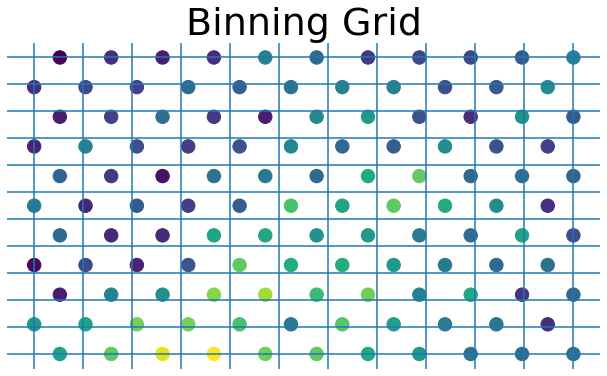

In [34]:
fig,ax = plt.subplots(1,1,figsize = (15,6))

_xx,_yy = ret.binnumber[0], ret.binnumber[1]
xx,yy = np.meshgrid(_xx,_yy)

for r in ret.x_edge:
    ax.axvline(x=r)
for r in ret.y_edge:
    ax.axhline(y=r)
ax.scatter(xv_hexagonal, yv_hexagonal, c = original_values, s=marker_size)


ax.set_title("Binning Grid",fontsize=fz - 2 )

ax.set_aspect("equal")
ax.axis("off")

# Interpolate values from hexagonal grid to square grid

In [35]:
from scipy.interpolate import griddata

In [54]:
positions = np.vstack([xv_hexagonal.ravel(), yv_hexagonal.ravel()]).T
new_vals = griddata(positions,original_values,(xx,yy),method = "cubic")
new_vals = new_vals.flatten()

In [55]:
new_positions = np.vstack([xx.flatten(), yy.flatten()]).T

### Map square grid to img

In [56]:
new_positions[:,0], new_positions[:,1] = new_positions[:,0] - 1, new_positions[:,1] - 1

In [57]:
I = grid2img(new_positions, new_vals, (N_X,N_Y))

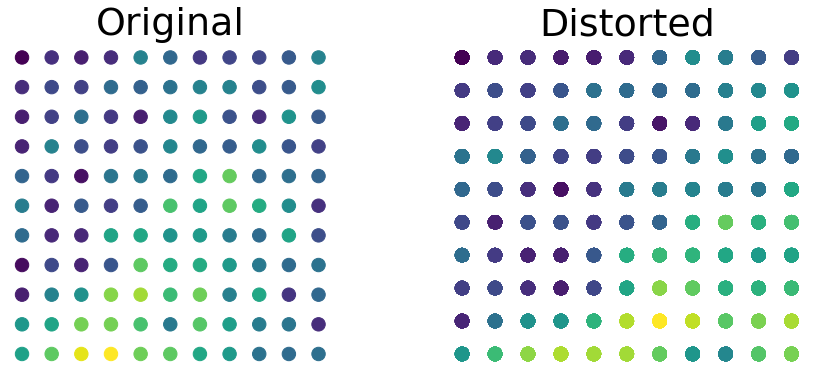

In [58]:
fig,ax = plt.subplots(1,2,figsize = (15,6))


ax[0].scatter(xv_square, yv_square, c = original_values, s=marker_size)
ax[1].scatter(xx,yy, c = new_vals, s=marker_size)




ax[0].set_title("Original",fontsize=fz - 2 )
ax[1].set_title("Distorted",fontsize=fz - 2 )


for aa in ax:
    aa.set_aspect("equal")
    aa.axis("off")

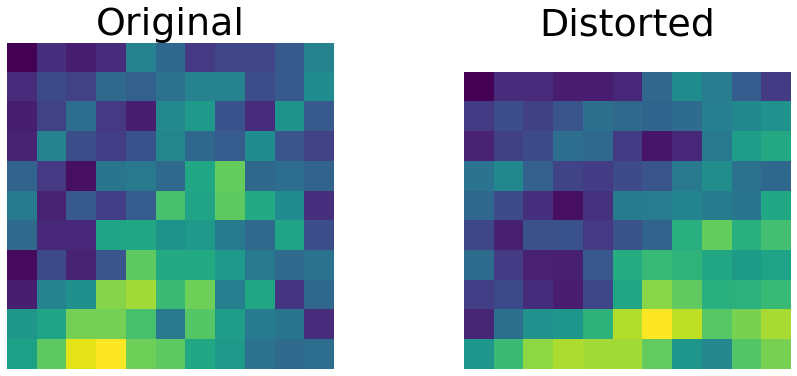

In [59]:
fig,ax = plt.subplots(1,2,figsize = (15,6))

ax[0].imshow(original_img)
ax[1].imshow(I)


ax[0].set_title("Original",fontsize=fz - 2 )
ax[1].set_title("Distorted",fontsize=fz - 2 )


for aa in ax:
    aa.set_aspect("equal")
    aa.axis("off")